In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt, sosfreqz, lfilter, iirnotch, filtfilt
import pywt
import numpy as np
from statsmodels.robust import mad
import pandas as pd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Loading Data

In [3]:
def read_signals(data_dir, channel):
    sigs = []
    titles = []
    for file in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file)
        titles.append(file.split("/")[-1])
        
        with open(file_path, "r") as f:
            lines = f.readlines()
            signal = []
            for i, l in enumerate(lines):
                try:
                    reading = int(l.split(',')[channel+1])
                    if(reading < 1023):
                        signal.append(reading)
                except:
                    pass
            sigs.append(np.array(signal))
    return sigs, titles

In [4]:
def Generate_dataframe_labeled(ch1_data,ch2_data,data_labels):

  df = pd.DataFrame(list(zip(ch1_data, ch2_data,data_labels)), columns = ['Channel1','Channel2','Label'])

  return df

In [11]:
ch1_sigs, titles = read_signals("/content/drive/My Drive/GP/Collected-data/raw/amr-left", 0)
ch2_sigs, titles = read_signals("/content/drive/My Drive/GP/Collected-data/raw/amr-left", 1)

# Onset detection preparation functions (denoising & binarizing)

In [6]:
def visualize_sigs(signals, titles, figsize=(20, 10)):
    fig, ax = plt.subplots(len(signals), 1, figsize=figsize)
    for i in range(len(signals)):
        ax[i].plot(signals[i])
        ax[i].set_title(titles[i])
    plt.tight_layout()
#titles=[]
def visualize_binary_sigs(binary_signals, signals, titles = titles, figsize = (20,100)):
    fig, ax = plt.subplots(len(signals), 1, figsize=figsize)
    for i in range(len(signals)):
        ax[i].plot(signals[i])
        ax[i].plot(binary_signals[i])
        ax[i].set_title(titles[i])
        plt.savefig(titles[i] ,format='png', bbox_inches='tight', dpi=200)

    plt.tight_layout()
    
def print_binary_sigs(binary_signals, signals, titles = titles):
    df = pd.DataFrame( columns = ['Active'])
    #fig, ax = plt.subplots(len(signals), 1, figsize=figsize)
    for i in range(len(signals)):
      for j in range(len(binary_signals[i])):
        df.append(pd.Series(binary_signals[i][j]),ignore_index=True)
    return df
    #print(binary_signals[i])
        

def binarize(signals):
    return signals - np.average(signals)

def overlay_sigs(sigs_raw, sigs_proc, sub_titles, figtitle, labels, figsize=(20, 10)):
    n_sigs = len(sigs_raw)
    fig, ax = plt.subplots(n_sigs, figsize=figsize)
    for i in range(n_sigs): 
        ax[i].plot(sigs_raw[i], color="r", label=labels[0])
        ax[i].plot(sigs_proc[i], color="b", label=labels[1])
        ax[i].set_title(sub_titles[i])
        ax[i].legend()
    fig.suptitle(figtitle)
    plt.tight_layout()

def denoise_TKEO(signal):
    tkeo_sig = (np.square(signal[1:-1]) - signal[:-2] * signal[2:])
    return tkeo_sig

def binarize_signal(signal, thresh):
    return signal > thresh


def get_binary_label_sig(signal, threshold):
    binary_signal = []
    for i in range(0, len(signal)):
        if signal[i] >= threshold:
            binary_signal.append(1)
        else:
            binary_signal.append(0)
    return binary_signal

def smoothing_values(frequency_rate = 1000, smooth_precentage = 20):
    smooth_precentage = smooth_precentage
    return int((smooth_precentage/100) * frequency_rate)
def Smoothing(signal, smoothing_value):
    smooth_signal = []
    #smoothing_value = smoothing_values()
    for i in range(0, len(signal)):
        if smoothing_value < i < len(signal) - smoothing_value:
            smooth_signal.append(np.mean(signal[i - smoothing_value:i + smoothing_value]))
        else:
            smooth_signal.append(0)
    return smooth_signal


def average_moving(sig, wind_size):
    wind_size = int(wind_size)
    ret = np.cumsum(sig, dtype=float)
    ret[wind_size:] = ret[wind_size:] - ret[:-wind_size]
    return np.concatenate((np.zeros(wind_size - 1), ret[wind_size - 1:] / wind_size))
def rectifying(signals, frequency_rate = 1000):
    rect_signal = np.absolute(signals)
    rect_signal = average_moving(rect_signal, frequency_rate / 10)
    return rect_signal


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos
def butter_bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y
    

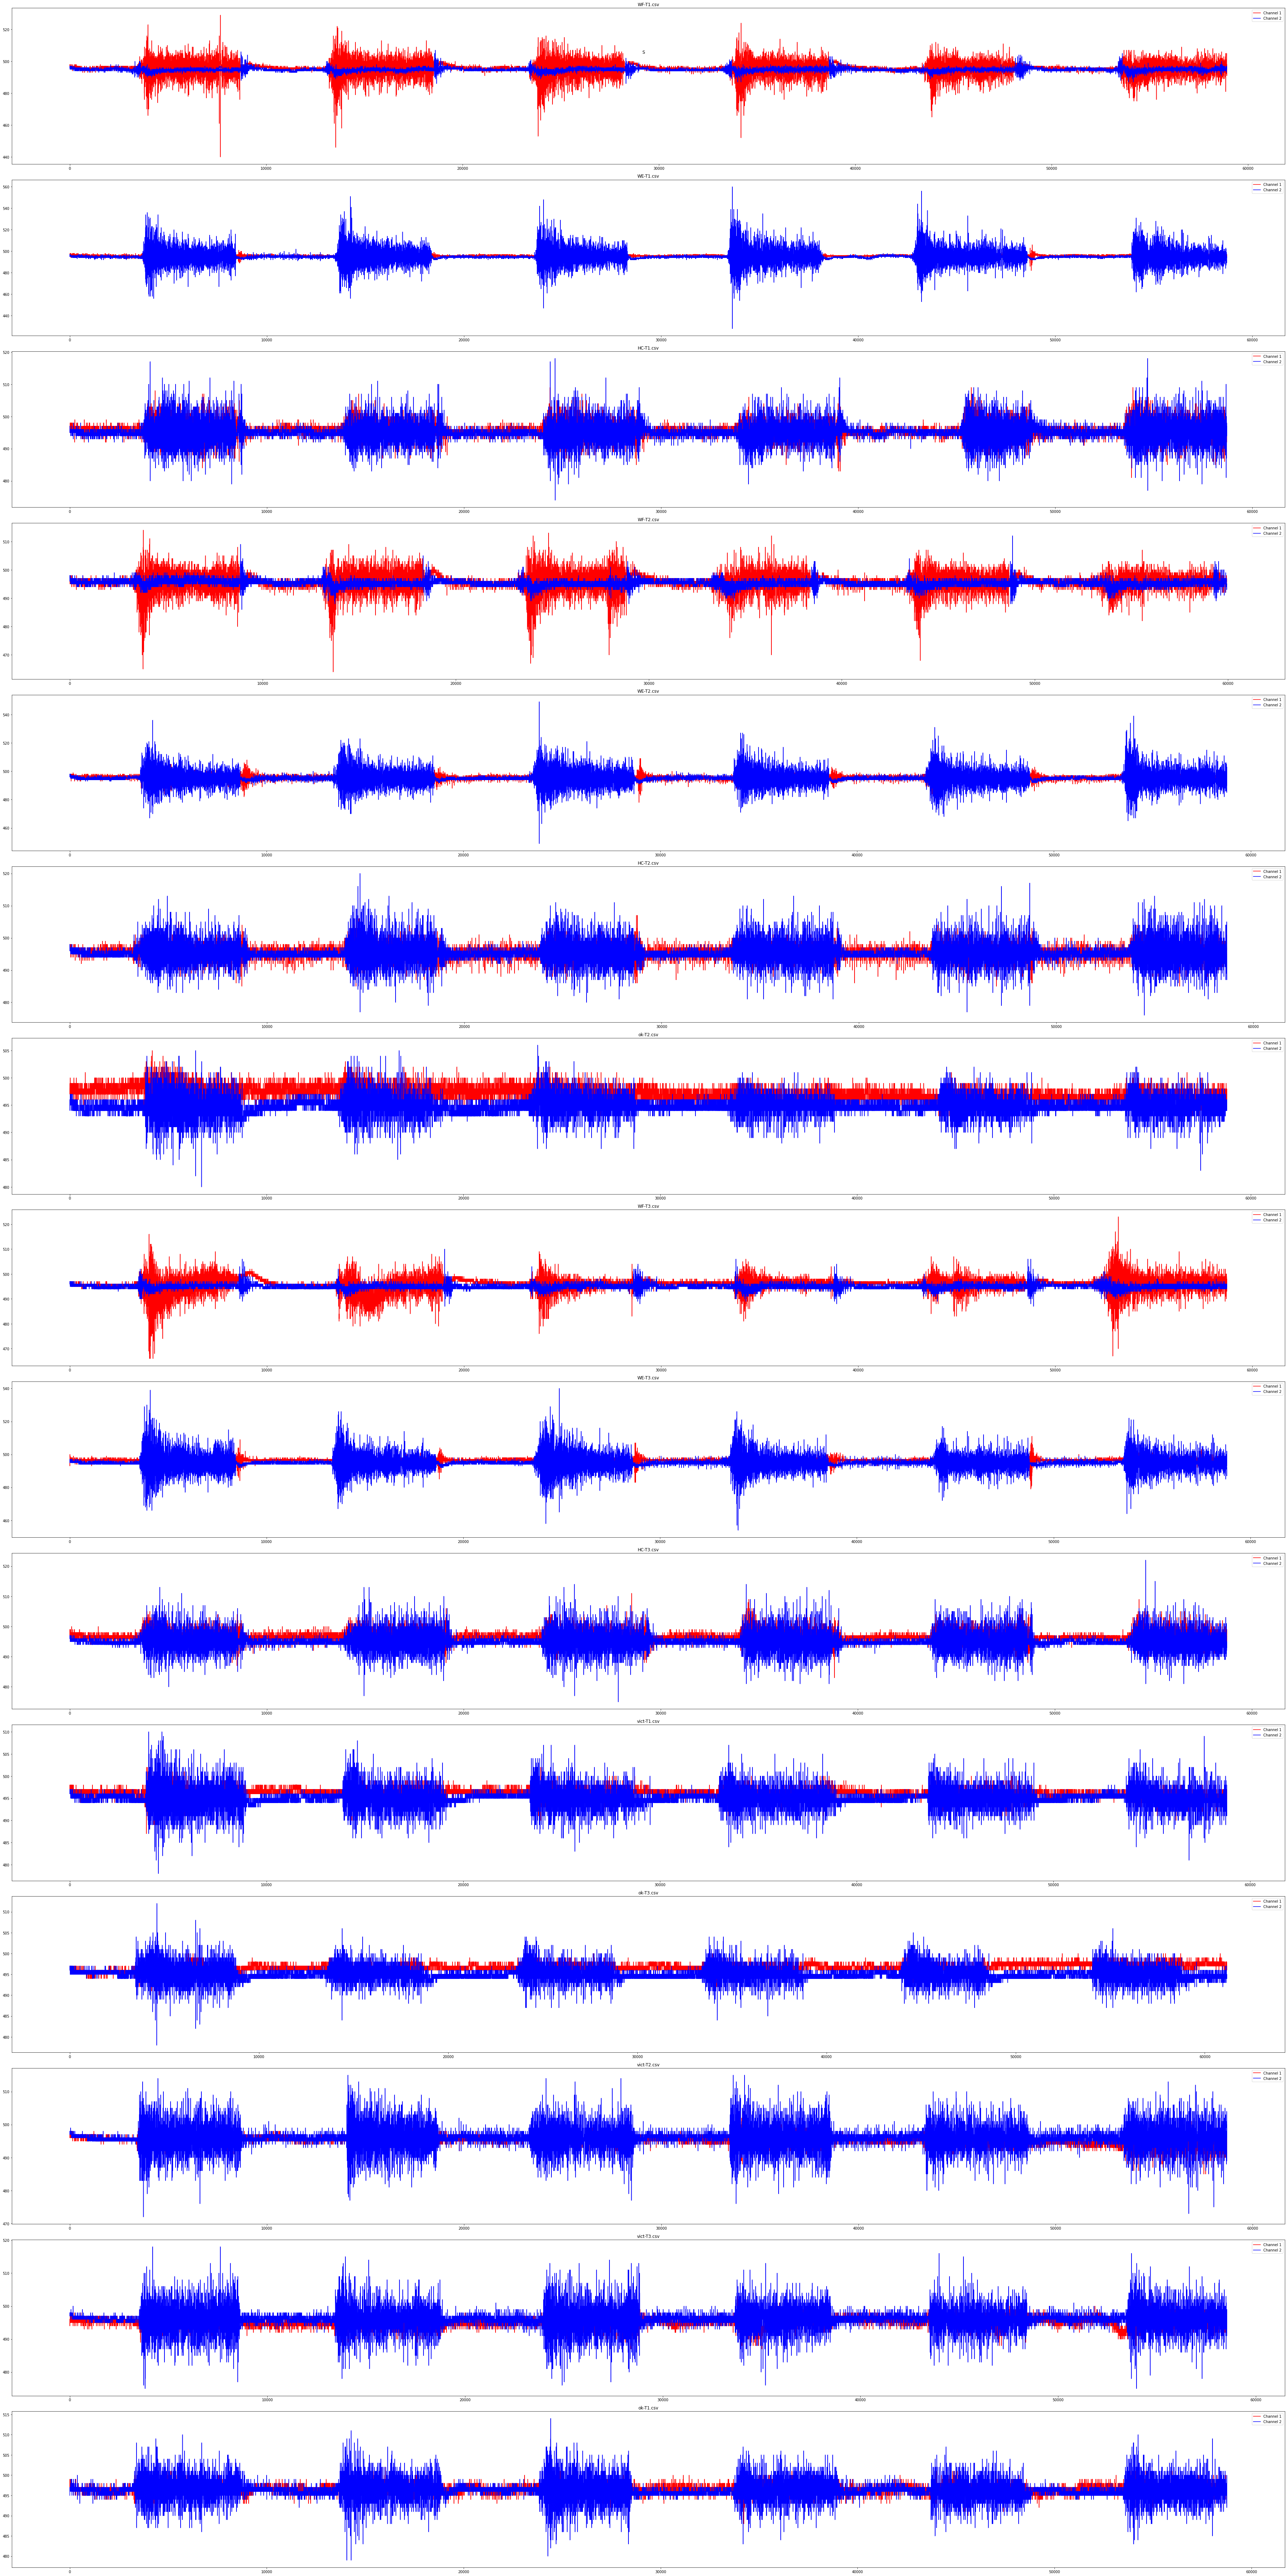

In [12]:
overlay_sigs(ch1_sigs, ch2_sigs, titles, "S", labels=["Channel 1", "Channel 2"], 
             figsize=(50,100))

# Onsetdetection algorithm

In [8]:
def find_onsets(signal=None, sampling_rate=1000., size=0.05, threshold=None):
    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    # full-wave rectification
    fwlo = np.abs(signal)

    # smooth
    size = int(sampling_rate * size)
    # mvgav, _ = st.smoother(signal=fwlo,
    #                        kernel='boxzen',
    #                        size=size,
    #                        mirror=True)
    mvgav = fwlo

    # threshold
    if threshold is None:
        aux = np.abs(mvgav)
        threshold = 1.2 * np.mean(aux) + 2.0 * np.std(aux, ddof=1)

    # find onsets
    length = len(signal)
    start = np.nonzero(mvgav > threshold)[0]
    stop = np.nonzero(mvgav <= threshold)[0]

    onsets = np.union1d(np.intersect1d(start - 1, stop),
                        np.intersect1d(start + 1, stop))

    if np.any(onsets):
        if onsets[-1] >= length:
            onsets[-1] = length - 1

    return (onsets)

# prepare channel1 signals for detection

In [9]:
def sigs_prep(ch1_sigs):
  bin_sig1 = [binarize(sig) for sig in ch1_sigs]
  filt = [butter_bandpass_filter(sig, 30, 300) for sig in bin_sig1]
  filt = [sig[30:] for sig in filt]
  tkeo_sigs = [denoise_TKEO(sig) for sig in filt]
  rect_signal = [rectifying(sig) for sig in tkeo_sigs]
  smoothing_value = smoothing_values()
  sm_sig1 = [Smoothing(sig, smoothing_value) for sig in rect_signal]
  return sm_sig1

In [13]:
bin_sig1 = [binarize(sig) for sig in ch1_sigs]
filt = [butter_bandpass_filter(sig, 30, 300) for sig in bin_sig1]
filt = [sig[30:] for sig in filt]
tkeo_sigs = [denoise_TKEO(sig) for sig in filt]
rect_signal = [rectifying(sig) for sig in tkeo_sigs]
smoothing_value = smoothing_values()
sm_sig1 = [Smoothing(sig, smoothing_value) for sig in rect_signal]

In [ ]:
print(np.dytypch1_ist)

[0, 2, 3, 7, 9, 13]


# prepare channel2 signals for detection

In [15]:
bin_sig2 = [binarize(sig) for sig in ch2_sigs]
filt = [butter_bandpass_filter(sig, 30, 300) for sig in bin_sig2]
filt = [sig[30:] for sig in filt]
tkeo_sigs = [denoise_TKEO(sig) for sig in filt]
rect_signal = [rectifying(sig) for sig in tkeo_sigs]
smoothing_value = smoothing_values()
sm_sig2 = [Smoothing(sig, smoothing_value) for sig in rect_signal]


# final labels for channel1 for all gestures

In [16]:
onset_sig1 =[]
for sig in sm_sig1:
  #onset.append(signals.emg.find_onsets(sig, sampling_rate=10000., size=0.05, threshold=None))
  onset_sig1.append(find_onsets(sig, sampling_rate=10000., size=0.05, threshold=None))
binary_label_sig1 = [get_binary_label_sig(sig, set_det.all()) for sig, set_det in zip(sm_sig1, onset_sig1)]
#visualize_binary_sigs(binary_label_sig1,sm_sig1)

In [ ]:
len(binary_label_sig1)

21

# final labels for channel2 for all gestures

In [17]:
onset_sig2 =[]
for sig in sm_sig2:
  #onset.append(signals.emg.find_onsets(sig, sampling_rate=10000., size=0.05, threshold=None))
  onset_sig2.append(find_onsets(sig, sampling_rate=10000., size=0.05, threshold=None))
binary_label_sig2 = [get_binary_label_sig(sig, set_det.all()) for sig, set_det in zip(sm_sig2, onset_sig2)]
#visualize_binary_sigs(binary_label_sig2,sm_sig2)

In [ ]:
len(binary_label_sig2)

15

In [14]:
def choose_best_channelLabeling(binary_label_sig1,binary_label_sig2):
  ch1_labels=[]
  ch2_labels=[]
  for i,s in enumerate(binary_label_sig1):
    count1_ch1 = binary_label_sig1[i].count(1)
    count0_ch1 = binary_label_sig1[i].count(0)
    sub_ch1=abs(count1_ch1-count0_ch1)
    count1_ch2 = binary_label_sig2[i].count(1)
    count0_ch2 = binary_label_sig2[i].count(0)
    sub_ch2=abs(count1_ch2-count0_ch2)
    if(sub_ch1<sub_ch2):
      ch1_labels.append(i)
      #print("channel1 ---> gesture "+titles[i].strip('.csv'))
    else:
      ch2_labels.append(i)
      #print("channel2 ---> gesture "+titles[i].strip('.csv'))
  return ch1_labels,ch2_labels

#ch1_labels

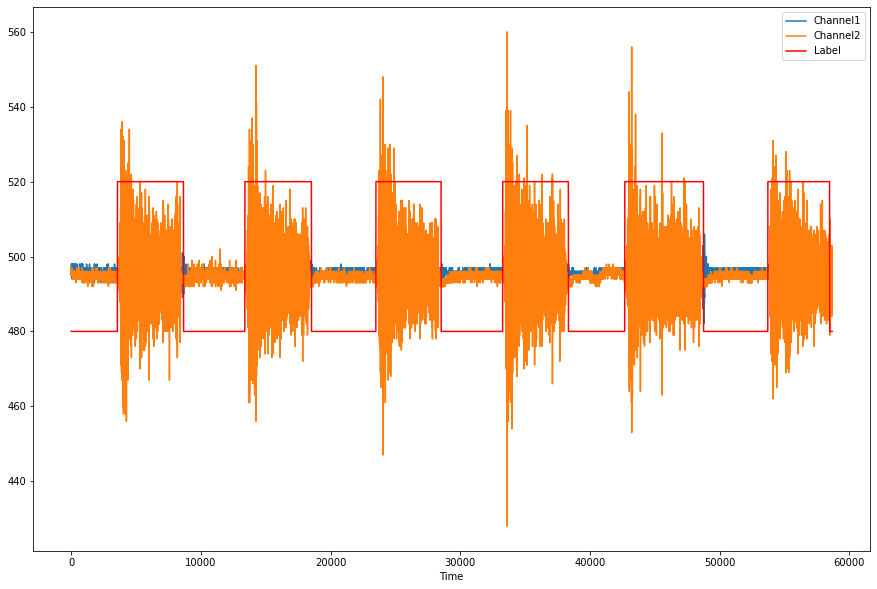

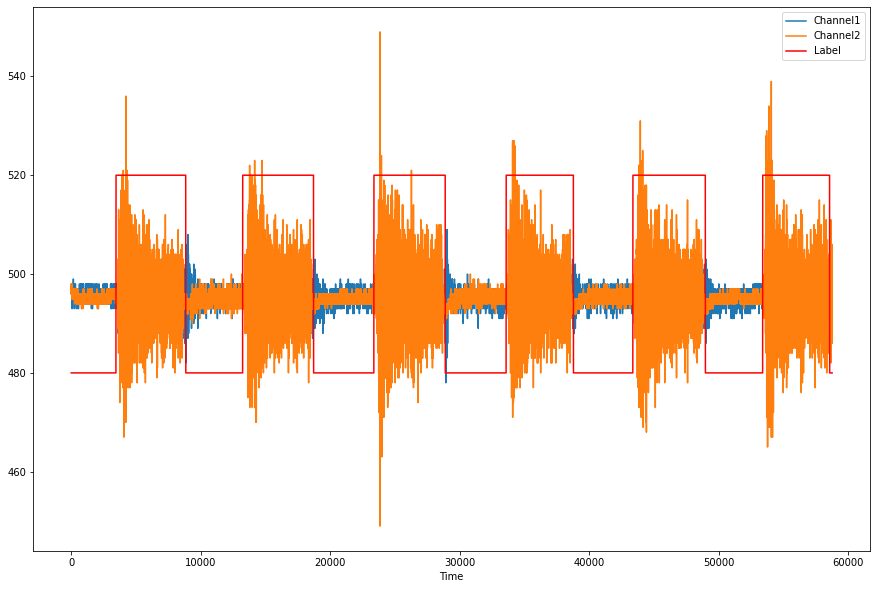

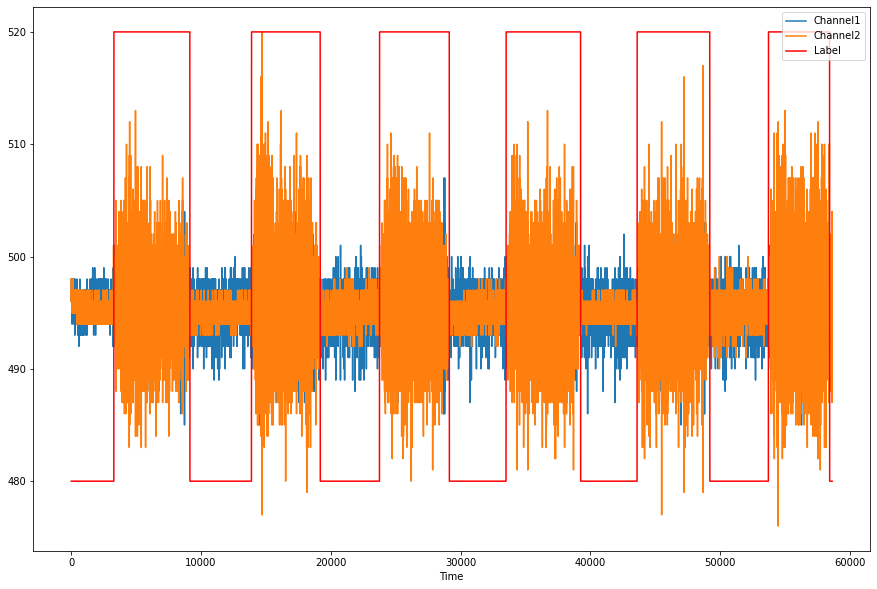

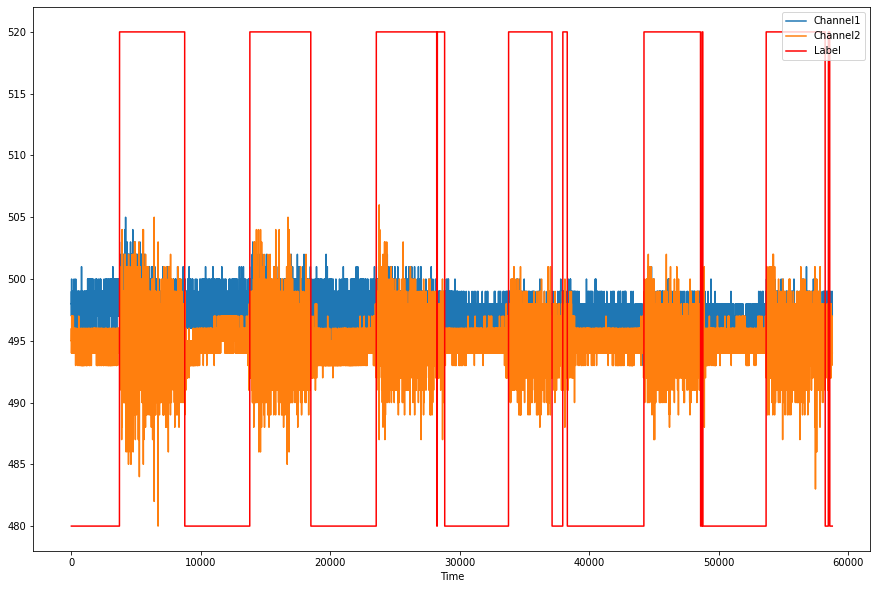

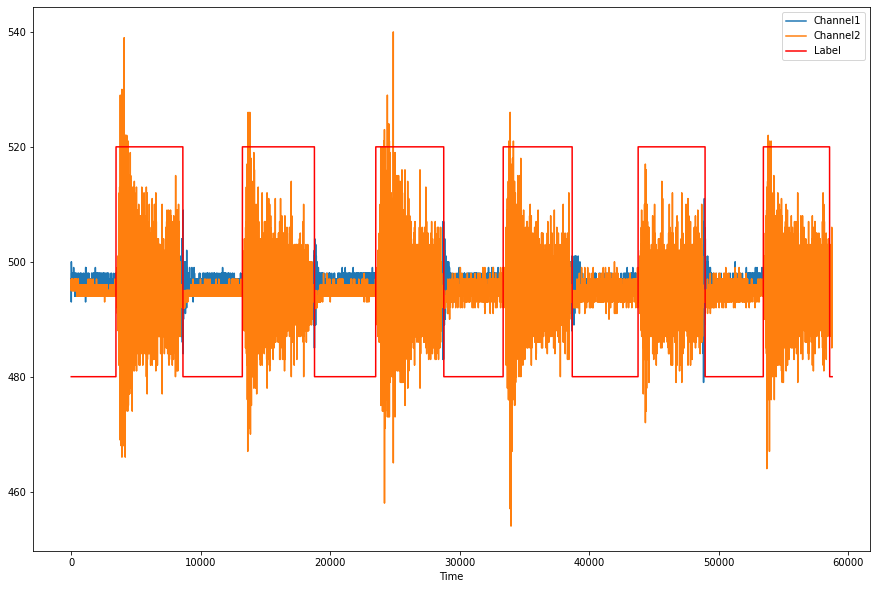

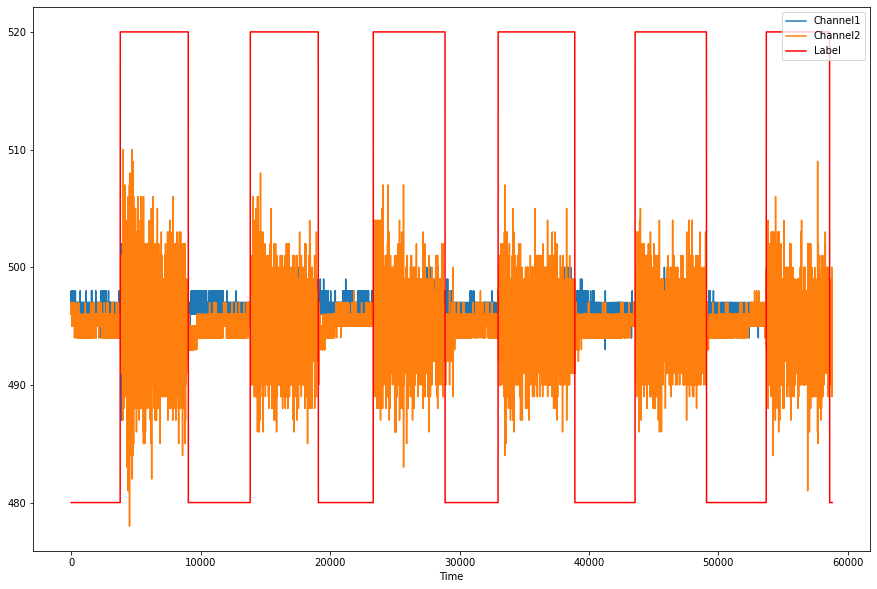

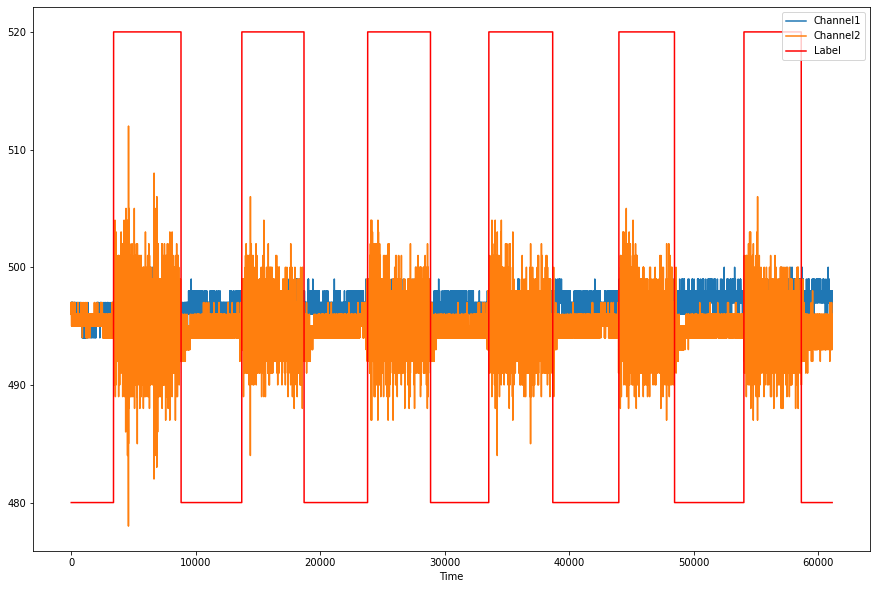

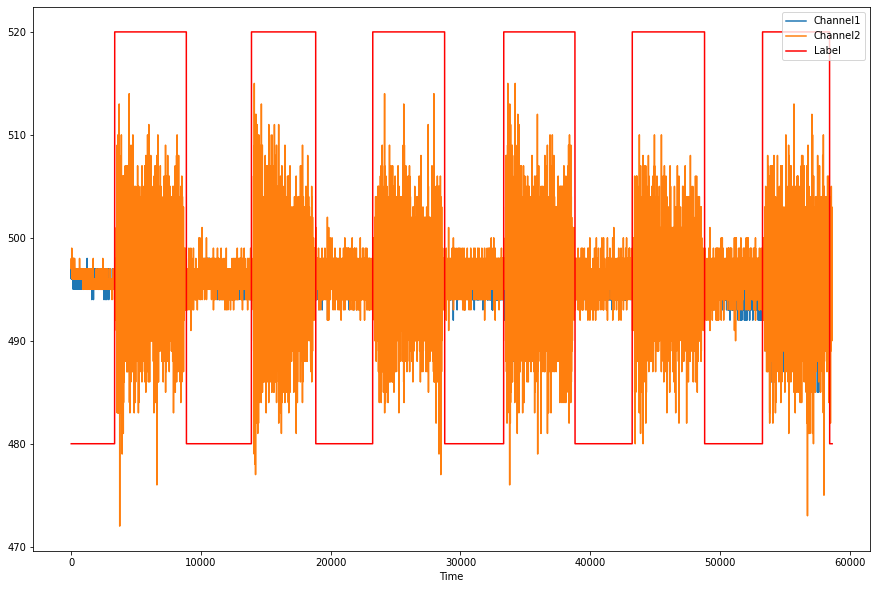

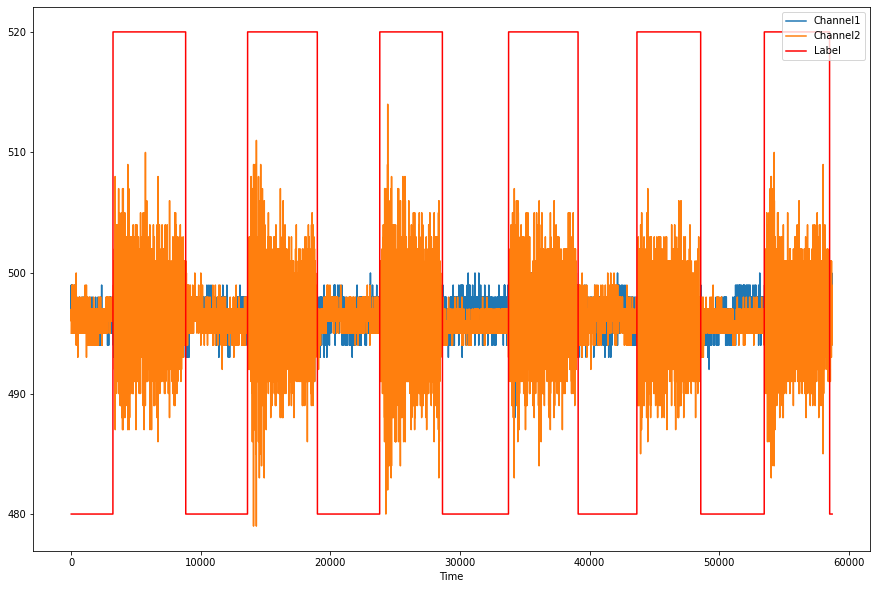

In [58]:
ch1_ist,ch2_list = choose_best_channelLabeling(binary_label_sig1,binary_label_sig2)
# for i in ch1_ist:
#   df = Generate_dataframe_labeled(list(ch1_sigs[i]),list(ch2_sigs[i]),list(binary_label_sig1[i]))
#   df["Label"]=df["Label"].apply(lambda x:x*40+480)
#   df["Channel1"].plot()
#   df["Channel2"].plot()
#   df["Label"].plot()
#   plt.show()
for i in ch2_list:
  plt.figure(figsize=(15,10))
  df = Generate_dataframe_labeled(list(ch1_sigs[i]),list(ch2_sigs[i]),list(binary_label_sig2[i]))
  df["Label"]=df["Label"].apply(lambda x:x*40+480)
  df["Channel1"].plot()
  df["Channel2"].plot()
  df["Label"].plot(color='r')
  plt.xlabel('Time')
  plt.legend(loc="upper right")
  plt.savefig('onset')
  plt.show()

In [13]:
from sys import path
data_dir = "/content/drive/My Drive/GP/Collected-data/raw/Lobna Data/"
output_dir = "/content/drive/My Drive/GP/Collected-data/Output/"
for root, dirs, files in os.walk(data_dir):
  pass
  #print(root)
  
  # for f in files:
  #   file_path = os.path.join(root, f)
  #   subj_name = root.split('/')[-1]
  #   ch_sigs,titles = read_signals
    #print(subj_name)
for dir in os.listdir(data_dir):
  channel_name = data_dir+dir
  print(channel_name)
  ch1_sigs, titles = read_signals(channel_name, 0)
  ch2_sigs, titles = read_signals(channel_name, 1)
  print(len(ch1_sigs))
  print(len(ch2_sigs))

  sig1 = sigs_prep(ch1_sigs)
  sig2 = sigs_prep(ch2_sigs)
  onset_sig1 =[]
  for sig in sig1:
    #onset.append(signals.emg.find_onsets(sig, sampling_rate=10000., size=0.05, threshold=None))
    onset_sig1.append(find_onsets(sig, sampling_rate=10000., size=0.05, threshold=None))
  binary_label_sig1 = [get_binary_label_sig(sig, set_det.all()) for sig, set_det in zip(sig1, onset_sig1)]
  onset_sig2 =[]
  for sig in sig2:
    #onset.append(signals.emg.find_onsets(sig, sampling_rate=10000., size=0.05, threshold=None))
    onset_sig2.append(find_onsets(sig, sampling_rate=10000., size=0.05, threshold=None))
  binary_label_sig2 = [get_binary_label_sig(sig, set_det.all()) for sig, set_det in zip(sig2, onset_sig2)]
  Generate_dataframe_labeled(list(ch1_sigs[14]),list(ch2_sigs[14]),list(binary_label_sig1[14]))
  ch1_list,ch2_list = choose_best_channelLabeling(binary_label_sig1,binary_label_sig2)
  
  for i in range(len(ch1_sigs)):
    if i in ch1_list:
      df1 = Generate_dataframe_labeled(list(ch1_sigs[i]),list(ch2_sigs[i]),list(binary_label_sig1[i]))
      if not os.path.exists(output_dir+dir):
        os.mkdir(output_dir+dir)
      df1.to_csv(output_dir+dir+'/'+titles[i],index=False)
    else:
      if not os.path.exists(output_dir+dir):
        os.mkdir(output_dir+dir)
      df2 = Generate_dataframe_labeled(list(ch1_sigs[i]),list(ch2_sigs[i]),list(binary_label_sig2[i]))
      df2.to_csv(output_dir+dir+'/'+titles[i],index=False)


/content/drive/My Drive/GP/Collected-data/raw/Lobna Data/Lobna
16
16
/content/drive/My Drive/GP/Collected-data/raw/Lobna Data/Samah
18
18


In [ ]:
Generate_dataframe_labeled(list(ch1_sigs[14]),list(ch2_sigs[14]),list(binary_label_sig1[14]))

,Channel1,Channel2,Label
0,497,495,0
1,498,496,0
2,498,496,0
3,498,496,0
4,498,496,0
...,...,...,...
58716,497,497,0
58717,496,496,0
58718,496,496,0
58719,497,496,0
